### First of all we need to download the packages we need for the project

In [1]:
# download the requirements which contains the packages needed for the project
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Codes\My projects\Semantic-Search-Prodata\semantic_search\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# include packages
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string
from gensim.similarities import MatrixSimilarity
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv, find_dotenv
import cohere
from annoy import AnnoyIndex
from utils import umap_reduct, sc_plot
import warnings
warnings.filterwarnings('ignore')


d:\Codes\My projects\Semantic-Search-Prodata\semantic_search\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
articles = pd.read_json('./wikipedia.json', lines=True)
articles

,id,title,text,url,wiki_id,views,paragraph_id,langs
0,0,24-hour clock,The 24-hour clock is a way of telling the time...,https://simple.wikipedia.org/wiki?curid=9985,9985,2450.625488,0,30
1,14,The Dark Knight Trilogy,"The ""Dark Knight"" Series is a set of three Chr...",https://simple.wikipedia.org/wiki?curid=377304,377304,1897.982666,0,13
2,19,Abella Danger,"Abella Danger (born November 19, 1995) is an A...",https://simple.wikipedia.org/wiki?curid=797944,797944,1748.024170,0,30
3,24,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,https://simple.wikipedia.org/wiki?curid=65655,65655,1564.210449,0,156
4,61,Carles Puigdemont,Carles Puigdemont i Casamajó (born 29 December...,https://simple.wikipedia.org/wiki?curid=540154,540154,1542.519531,0,81
...,...,...,...,...,...,...,...,...
1995,34633,1st century,"During this period Europe, North Africa and th...",https://simple.wikipedia.org/wiki?curid=24589,24589,122.295425,0,133
1996,34653,Operation Restore Hope,The Operation Restore Hope was an operation of...,https://simple.wikipedia.org/wiki?curid=427200,427200,122.192032,0,12
1997,34655,Rumi,Jalal ad-Din Muhammad Rumi (30 September 1207 ...,https://simple.wikipedia.org/wiki?curid=64995,64995,122.192032,0,101
1998,34669,Korean War,"The Korean War (Korean: 한국전잴, Russian: Корейск...",https://simple.wikipedia.org/wiki?curid=7537,7537,122.175140,0,120


In [4]:
articles = articles[['title', 'text']]
articles.head()

,title,text
0,24-hour clock,The 24-hour clock is a way of telling the time...
1,The Dark Knight Trilogy,"The ""Dark Knight"" Series is a set of three Chr..."
2,Abella Danger,"Abella Danger (born November 19, 1995) is an A..."
3,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...
4,Carles Puigdemont,Carles Puigdemont i Casamajó (born 29 December...


In [5]:
articles['plot'] = articles['text'] + ' ' + articles['title']
articles['plot_tokenized'] = preprocess_documents(articles['plot'])
articles.head()

,title,text,plot,plot_tokenized
0,24-hour clock,The 24-hour clock is a way of telling the time...,The 24-hour clock is a way of telling the time...,"[hour, clock, wai, tell, time, dai, run, midni..."
1,The Dark Knight Trilogy,"The ""Dark Knight"" Series is a set of three Chr...","The ""Dark Knight"" Series is a set of three Chr...","[dark, knight, seri, set, christoph, nolan, ba..."
2,Abella Danger,"Abella Danger (born November 19, 1995) is an A...","Abella Danger (born November 19, 1995) is an A...","[abella, danger, born, novemb, american, porno..."
3,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,"[cristiano, ronaldo, do, santo, aveiro, born, ..."
4,Carles Puigdemont,Carles Puigdemont i Casamajó (born 29 December...,Carles Puigdemont i Casamajó (born 29 December...,"[carl, puigdemont, casamajó, born, decemb, pre..."


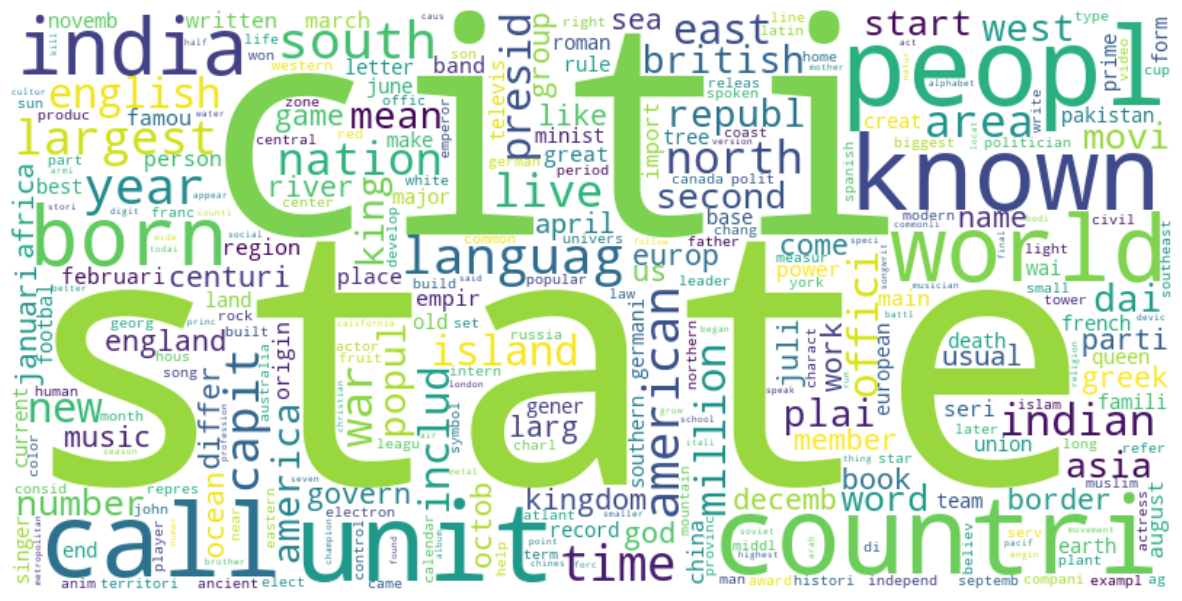

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(articles['plot_tokenized'])).value_counts()[:300]
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=300).generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 1. Semantic search with LSI(Latent Semantic Indexing)

In [7]:
dictionary = corpora.Dictionary(articles['plot_tokenized'])
example = preprocess_string('Cristiano Ronaldo is a football player')
stop_ids = [(word, dictionary.token2id[word]) for word in example if word in dictionary.token2id]
stop_ids

[('cristiano', 75), ('ronaldo', 88), ('footbal', 79), ('player', 803)]

In [8]:
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 10]]
dict_tokens

[[['base', 0],
  ['call', 1],
  ['canada', 2],
  ['clock', 3],
  ['continent', 4],
  ['dai', 5],
  ['divid', 6],
  ['english', 7],
  ['format', 8],
  ['hour', 9],
  ['intern', 10]]]

In [9]:
corpus = [dictionary.doc2bow(desc) for desc in articles['plot_tokenized']]

word_frequencies = [[(dictionary[id], id, frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('base', 0, 1), ('call', 1, 1), ('canada', 2, 1), ('clock', 3, 2), ('continent', 4, 1), ('dai', 5, 1), ('divid', 6, 1), ('english', 7, 1), ('format', 8, 1), ('hour', 9, 3), ('intern', 10, 1), ('iso', 11, 1), ('kingdom', 12, 1), ('midnight', 13, 2), ('militari', 14, 1), ('notat', 15, 1), ('number', 16, 1), ('part', 17, 2), ('railwai', 18, 1), ('rare', 19, 1), ('refer', 20, 1), ('run', 21, 1), ('speak', 22, 1), ('standard', 23, 1), ('tell', 24, 1), ('time', 25, 5), ('unit', 26, 1), ('us', 27, 1), ('wai', 28, 1), ('world', 29, 1)], [('appear', 30, 1), ('bale', 31, 1), ('batman', 32, 2), ('begin', 33, 1), ('cain', 34, 1), ('christian', 35, 1), ('christoph', 36, 1), ('cillian', 37, 1), ('dark', 38, 4), ('freeman', 39, 1), ('gari', 40, 1), ('includ', 41, 1), ('knight', 42, 4), ('michael', 43, 1), ('morgan', 44, 1), ('movi', 45, 2), ('murphi', 46, 1), ('nolan', 47, 1), ('oldman', 48, 1), ('rise', 49, 1), ('seri', 50, 1), ('set', 51, 1), ('trilogi', 52, 1)], [('abella', 53, 2), ('actress', 5

In [10]:
articles_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
articles_lsi_model = gensim.models.LsiModel(articles_tfidf_model[corpus], id2word=dictionary, num_topics=384)

In [11]:
print(articles_tfidf_model[corpus[0]])

[(0, 0.09655396263425577), (1, 0.050564764505760376), (2, 0.11148200203395355), (3, 0.3331926156083443), (4, 0.15194670062578577), (5, 0.09125610379865134), (6, 0.11770704162899485), (7, 0.07816857196223358), (8, 0.16659630780417214), (9, 0.40526994635915353), (10, 0.11011611086502275), (11, 0.17822435518859162), (12, 0.08534458390474685), (13, 0.4359618235773225), (14, 0.11950001877778525), (15, 0.19810263348862642), (16, 0.09195560905084411), (17, 0.19742248397690465), (18, 0.19810263348862642), (19, 0.15496826041975267), (20, 0.10466598463888056), (21, 0.1204403749413315), (22, 0.116019596498187), (23, 0.13066920367657336), (24, 0.13353942647805475), (25, 0.3436944025564088), (26, 0.05309813214895023), (27, 0.0876869704527075), (28, 0.10203310079360046), (29, 0.05450191776899901)]


In [12]:
gensim.corpora.MmCorpus.serialize('articles_tfidf_model_mm', articles_tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize('articles_lsi_model_mm',articles_lsi_model[articles_tfidf_model[corpus]])

In [13]:
articles_tfidf_corpus = gensim.corpora.MmCorpus('articles_tfidf_model_mm')
articles_lsi_corpus = gensim.corpora.MmCorpus('articles_lsi_model_mm')

print(articles_tfidf_corpus)
print(articles_lsi_corpus)

MmCorpus(2000 documents, 10988 features, 50766 non-zero entries)
MmCorpus(2000 documents, 384 features, 768000 non-zero entries)


In [14]:
articles_index = MatrixSimilarity(articles_lsi_corpus, num_features = articles_lsi_corpus.num_terms)
articles_index.get_similarities(articles_lsi_corpus[0])

array([ 0.73318243, -0.00115447, -0.02326263, ...,  0.0411127 ,
        0.00961284,  0.09889706], dtype=float32)

In [15]:
def search_lsi(query, top_n=5):
    query = preprocess_string(query)
    query = dictionary.doc2bow(query)
    query = articles_lsi_model[query]
    similarities = articles_index.get_similarities(query)
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    top_results = articles.iloc[top_indices][['title', 'text']].reset_index(drop=True)
    top_results['similarity'] = similarities[top_indices]
    return top_results

In [16]:
search_lsi('Cristiano Ronaldo is a football player')

,title,text,similarity
0,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,0.826689
1,Portugal national football team,Portugal national football team is the nationa...,0.778327
2,American football,"American football, referred to as football in ...",0.721025
3,Ronaldinho,"Ronaldo de Assis Moreira (born 21 March 1980),...",0.614982
4,Argentina national football team,Argentina national football team is the nation...,0.607981


In [17]:
def preprocess_text(text):
    text = preprocess_string(text)
    text = ' '.join(text)
    return text

In [18]:
articles['cleaned_plot'] = articles['plot'].apply(preprocess_text)
articles.head()

,title,text,plot,plot_tokenized,cleaned_plot
0,24-hour clock,The 24-hour clock is a way of telling the time...,The 24-hour clock is a way of telling the time...,"[hour, clock, wai, tell, time, dai, run, midni...",hour clock wai tell time dai run midnight midn...
1,The Dark Knight Trilogy,"The ""Dark Knight"" Series is a set of three Chr...","The ""Dark Knight"" Series is a set of three Chr...","[dark, knight, seri, set, christoph, nolan, ba...",dark knight seri set christoph nolan batman mo...
2,Abella Danger,"Abella Danger (born November 19, 1995) is an A...","Abella Danger (born November 19, 1995) is an A...","[abella, danger, born, novemb, american, porno...",abella danger born novemb american pornograph ...
3,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,"[cristiano, ronaldo, do, santo, aveiro, born, ...",cristiano ronaldo do santo aveiro born februar...
4,Carles Puigdemont,Carles Puigdemont i Casamajó (born 29 December...,Carles Puigdemont i Casamajó (born 29 December...,"[carl, puigdemont, casamajó, born, decemb, pre...",carl puigdemont casamajó born decemb presid ca...


In [19]:
model_bert = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2', cache_folder='./.cache/')
embeddings_bert = np.array(model_bert.encode(articles['cleaned_plot'].tolist(),show_progress_bar=True))

Batches: 100%|██████████| 63/63 [01:58<00:00,  1.89s/it]


In [20]:
print(embeddings_bert.shape)

(2000, 384)


In [21]:
def search_bert(query, top_n=5):
    query_clean = preprocess_text(query)
    query_embedding = model_bert.encode(query_clean).reshape(1,-1)
    similarities = cosine_similarity(embeddings_bert,query_embedding).flatten()
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    top_results = articles.iloc[top_indices][['title', 'text']].reset_index(drop=True)
    top_results['similarity'] = similarities[top_indices]
    return top_results

In [22]:
query = 'Cristiano Ronaldo is a football player'
search_bert(query)

,title,text,similarity
0,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,0.665374
1,Ronaldinho,"Ronaldo de Assis Moreira (born 21 March 1980),...",0.612995
2,Neymar,"Neymar da Silva Santos Junior, known as Neymar...",0.588709
3,Portugal national football team,Portugal national football team is the nationa...,0.558468
4,Lionel Messi,"Lionel Andrés ""Leo"" Messi Cuccittini (Spanish ...",0.543975


In [23]:
# read local .env file
_ = load_dotenv(find_dotenv())

In [24]:
co = cohere.Client(os.environ['COHERE_API_KEY'])

In [25]:
embeds = co.embed(list(articles['plot']), model='embed-english-light-v2.0').embeddings

In [26]:
articles['emb'] = embeds
articles.head()

,title,text,plot,plot_tokenized,cleaned_plot,emb
0,24-hour clock,The 24-hour clock is a way of telling the time...,The 24-hour clock is a way of telling the time...,"[hour, clock, wai, tell, time, dai, run, midni...",hour clock wai tell time dai run midnight midn...,"[-2.1679688, -0.5917969, -1.0917969, 3.5644531..."
1,The Dark Knight Trilogy,"The ""Dark Knight"" Series is a set of three Chr...","The ""Dark Knight"" Series is a set of three Chr...","[dark, knight, seri, set, christoph, nolan, ba...",dark knight seri set christoph nolan batman mo...,"[-0.36279297, 0.09295654, 0.29907227, 1.702148..."
2,Abella Danger,"Abella Danger (born November 19, 1995) is an A...","Abella Danger (born November 19, 1995) is an A...","[abella, danger, born, novemb, american, porno...",abella danger born novemb american pornograph ...,"[-1.3085938, -0.18981934, 0.6225586, -0.176269..."
3,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,"[cristiano, ronaldo, do, santo, aveiro, born, ...",cristiano ronaldo do santo aveiro born februar...,"[-3.6894531, 1.5107422, -0.15039062, 2.5253906..."
4,Carles Puigdemont,Carles Puigdemont i Casamajó (born 29 December...,Carles Puigdemont i Casamajó (born 29 December...,"[carl, puigdemont, casamajó, born, decemb, pre...",carl puigdemont casamajó born decemb presid ca...,"[-1.8222656, 1.4648438, 0.66064453, -1.0146484..."


In [27]:
plot_articles = articles[['title', 'text']]
umap_embeds = umap_reduct(embeds)
plot_articles['x'] = umap_embeds[:, 0]
plot_articles['y'] = umap_embeds[:, 1]
chart = sc_plot(plot_articles)
chart.interactive()

alt.Chart(...)

In [28]:
query_title = ''
query_text = 'Footballer gained 5 Baloon d\'Ors'
query_plot = query_title + ' ' + query_text

In [29]:
query_embed = co.embed([query_plot], model='embed-english-light-v2.0').embeddings
new_embeds = embeds + query_embed
umap_new_embeds = umap_reduct(new_embeds)
plot_articles_new = plot_articles.copy()
new_row = pd.DataFrame({'title': [query_title], 'text': [query_text], 'x': [umap_new_embeds[-1, 0]], 'y': [umap_new_embeds[-1, 1]]})
plot_articles_new = pd.concat([plot_articles_new, new_row], ignore_index=True)
plot_articles_new['x'] = umap_new_embeds[:, 0]
plot_articles_new['y'] = umap_new_embeds[:, 1]

In [30]:
chart_prev = sc_plot(plot_articles_new)
query_point = sc_plot(new_row, size=100, color='red')
chart_combined = chart_prev + query_point
chart_combined.interactive()

alt.LayerChart(...)

In [31]:

search_index = AnnoyIndex(np.array(embeds).shape[1], 'angular')
for i, v in enumerate(embeds):
    search_index.add_item(i, v)

search_index.build(10) # 10 trees
search_index.save('search_index.ann')

True

In [32]:
def search_cohere(query, top_n=5):
  
  query_embed = co.embed([query], model='embed-english-light-v2.0').embeddings

  similar_item_ids = search_index.get_nns_by_vector(query_embed[0],
                                                    top_n,
                                                  include_distances=True)
  results = pd.DataFrame(data={'title': articles.iloc[similar_item_ids[0]]['title'],
                              'texts': articles.iloc[similar_item_ids[0]]['text'],
                              'distance': similar_item_ids[1]})

  print(articles.iloc[similar_item_ids[0]]['text'])
    
  return results

In [33]:
query = "The most famous football player in the world"

In [34]:
search_cohere(query)

3       Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...
1339    George Best (22 May 1946 – 25 November 2005) w...
524     Diego Armando Maradona (30 October 1960 – 25 N...
532     Edson Arantes do Nascimento, more commonly kno...
162     Neymar da Silva Santos Junior, known as Neymar...
Name: text, dtype: object


,title,texts,distance
3,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (born 5 Fe...,0.986872
1339,George Best,George Best (22 May 1946 – 25 November 2005) w...,1.041317
524,Diego Maradona,Diego Armando Maradona (30 October 1960 – 25 N...,1.042972
532,Pelé,"Edson Arantes do Nascimento, more commonly kno...",1.044721
162,Neymar,"Neymar da Silva Santos Junior, known as Neymar...",1.061025


In [35]:
query = 'The country which won the FIFA World Cup most times'

In [36]:
search_lsi(query)

,title,text,similarity
0,FIFA World Cup,The FIFA World Cup is the most watched tournam...,1.478474
1,Germany national football team,"The Germany national football team ( or ""Die M...",1.460088
2,2022 FIFA World Cup,"The Qatar 2022, FIFA World Cup is the 22nd FIF...",1.455151
3,2018 FIFA World Cup disciplinary record,"In the 2018 FIFA World Cup, which is taking pl...",1.259677
4,FIFA,"The (FIFA ; French for ""International Federati...",0.976881


In [37]:
search_bert(query)

,title,text,similarity
0,FIFA World Cup,The FIFA World Cup is the most watched tournam...,0.557410
1,Germany national football team,"The Germany national football team ( or ""Die M...",0.498683
2,2018 FIFA World Cup disciplinary record,"In the 2018 FIFA World Cup, which is taking pl...",0.481611
3,Portugal national football team,Portugal national football team is the nationa...,0.479932
4,Brazil national football team,Brazil national football team is the national ...,0.474083


In [38]:
search_cohere(query)

873     The FIFA World Cup is the most watched tournam...
936     Brazil national football team is the national ...
1915    The (FIFA ; French for "International Federati...
1017    The Germany national football team ( or "Die M...
799     The Qatar 2022, FIFA World Cup is the 22nd FIF...
Name: text, dtype: object


,title,texts,distance
873,FIFA World Cup,The FIFA World Cup is the most watched tournam...,0.864443
936,Brazil national football team,Brazil national football team is the national ...,0.992068
1915,FIFA,"The (FIFA ; French for ""International Federati...",1.026002
1017,Germany national football team,"The Germany national football team ( or ""Die M...",1.043607
799,2022 FIFA World Cup,"The Qatar 2022, FIFA World Cup is the 22nd FIF...",1.117303
